In [176]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
from copy import deepcopy
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение и обработка данных 

In [177]:
data = pd.read_excel('data_v02.xlsx')
data.head()

,Unnamed: 0,ADDRESS,CITY,REGION,Postamat_daily,cashbox_daily,Postamat_trend,cashbox_MAX,cashbox_trend,hh_500,value1,value2,POPULATION,NEAR_Malls,NEAR_Business_centers,NEAR_metro_rjd,NEAR_Stations,macro_salary_avg_yearly,Salary
0,0,"г.Калуга, Литейная ул., 25/15",КАЛУГА,Калужская область,NaN,3.3,NaN,13.0,1.0,7696.0,10099,3382,324698,0,0,NaN,остановка,423321,45379
1,1,"г.Калуга, Гагарина ул., 1",КАЛУГА,Калужская область,NaN,NaN,NaN,NaN,NaN,6369.0,10068,3236,324698,1,1,NaN,остановка,423321,45379
2,2,"г.Калуга, Кибальчича ул., 25",КАЛУГА,Калужская область,NaN,3.1,NaN,12.0,1.0,5553.0,10100,3436,324698,1,0,NaN,NaN,423321,45379
3,3,"г.Калуга, Пестеля ул., 60/49",КАЛУГА,Калужская область,3.0,2.2,0.0,12.0,1.0,7162.0,10099,3257,324698,0,0,NaN,NaN,423321,45379
4,4,"г.Калуга, Ленина ул., 81",КАЛУГА,Калужская область,1.0,2.0,0.0,9.0,1.0,6269.0,10096,3195,324698,1,0,NaN,остановка,423321,45379


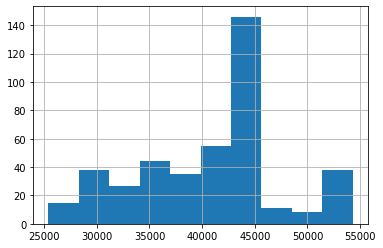

In [178]:
#Подтянули средние зарплаты по округам - данная переменная и производные от нее оказались не эффективны
data['Salary'].hist()
data['sal_2'] = data['Salary'].apply(lambda x: x**2)

In [179]:
# Функции для расчета переменнных dum0 и dum1 - наличие в пунтке выдачи постамата/кассы соответсвенно
# Функция для работы с регионом
def dum(x):
    if str(x) == 'nan':
        return 0
    else :
        return 1 
    
def sm(x, y):
    if str(x) == 'nan' and str(y) != 'nan':
        return y
    else :
        return 1 
def reg(x):
    if x == 'Калужская область':
        return 0 
    else :
        return 1   

In [180]:
data['dum0'] = data['Postamat_daily'].apply(dum)
data['dum1'] = data['cashbox_daily'].apply(dum)
data['Postamat_daily_filna'] = data['Postamat_daily'].fillna(0)
data['cashbox_daily_filna'] = data['cashbox_daily'].fillna(0)

In [181]:
# Целевой переменной для линейной регрессии будем считать сумму выдач в постамате и на кассе
data['target'] = data['Postamat_daily_filna'] + data['cashbox_daily_filna']

In [182]:
# Добавляем дополнительные переменные
data['sum_dum'] = data['dum0'] + data['dum1']
data['dum_p'] = data['dum0']*data['dum1']
data['dum_region'] = data['REGION'].apply(reg)
data['station'] = data['NEAR_Stations'].apply(dum)
data['rjd'] = data['NEAR_metro_rjd'].apply(dum)

In [183]:
# Выделяем действующие пункты выдачи
data_exs = data[data['sum_dum'] > 0]

In [184]:
# Подтягиваем для каждого пунтка минимально расстояние до соседи (возможность конкуренции между пунктами)
rr = np.load('distance_matrix_1.npy')
nearest = []
for x in rr:
    nearest.append(sorted(x)[1])
#print(nearest)
data_exs['d'] = nearest

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [185]:
# Подтягиваем флаг наличия соседа в радиусе 500м (такое расстояние оказывается статистически значимым)
near3d = []
for x in nearest:
    if x < 0.5:
        near3d.append(1)
    else:
        near3d.append(0)
        
data_exs['ff'] = near3d

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [186]:
# Выделяем наиболее осмысленные переменные
XX = data_exs[['target', 'dum0', 'dum1', 'dum_p', 'dum_region', 'hh_500', 'value1', 'value2', 'NEAR_Malls', 'NEAR_Business_centers',
             'rjd', 'station', 'd', 'ff', 'Salary', 'sal_2', 'cashbox_MAX']]

In [187]:
df = XX[XX.index != 37] # эта строка выброс (очень большой остаток на ней)

## Построение модели

In [188]:
# Строим линейную регрессию, смотрим на статистику
m1 = smf.ols('target ~ dum0 + dum1 + dum_region + hh_500 + value2 + NEAR_Malls + NEAR_Business_centers + ff', 
             data= df)
fitted = m1.fit()
print (fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     39.98
Date:                Sun, 01 Dec 2019   Prob (F-statistic):           4.98e-36
Time:                        12:33:51   Log-Likelihood:                -246.98
No. Observations:                 188   AIC:                             512.0
Df Residuals:                     179   BIC:                             541.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.76

In [189]:
# Смотрим на возможность предсказать cashbox_MAX с целью анализа нехватки кол-ва ячеек постамата - простой линейной регрессии
# для этого не хватает
m2 = smf.ols('cashbox_MAX ~ dum0 + dum1 + dum_region + hh_500 + value2 + value1 + NEAR_Malls + NEAR_Business_centers + ff',
data= df)
fitted2 = m2.fit()
print (fitted2.summary())

                            OLS Regression Results                            
Dep. Variable:            cashbox_MAX   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     6.798
Date:                Sun, 01 Dec 2019   Prob (F-statistic):           1.51e-07
Time:                        12:33:52   Log-Likelihood:                -381.41
No. Observations:                 152   AIC:                             780.8
Df Residuals:                     143   BIC:                             808.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                21.85

<Figure size 576x504 with 0 Axes>

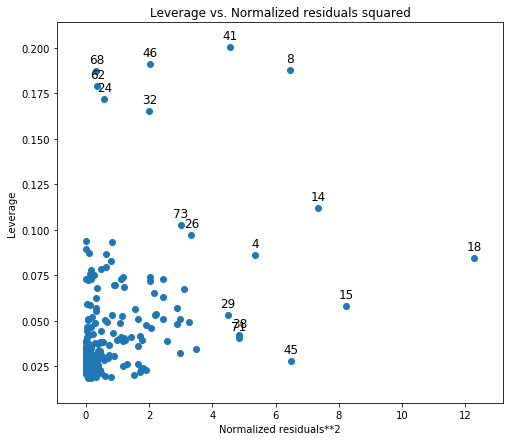

In [190]:
#для остатков
plt.figure(figsize(8,7))
plot_leverage_resid2(fitted)
pylab.show()

In [191]:
# Подтягиваем расстояние до ближайшего соседа для всей выборки для оптимизации расположения в будущем
rrr = np.load('min_distances.npy')
data['d'] = rrr
near2d = []
for x in rrr:
    if x < 0.5:
        near2d.append(1)
    else:
        near2d.append(0)
data['ff'] = near2d

## Подготовка данных для оптимизации

In [192]:
# Подготовка данных для оптимизации - вычитаем dum0 and dum1 чтобы потом уметь добавить/вычесть данный пункт выдачи
data['pres_raw'] = fitted.predict(data[['dum0', 'dum1', 'dum_region', 'hh_500', 'value2', 'NEAR_Malls', 'NEAR_Business_centers',
                                       'ff']]) 
data['pres_raw_'] = data['pres_raw'] - fitted.params['dum0'] * data['dum0']  -  fitted.params['dum1'] * data['dum1']

In [193]:
# Для учета взаимодейтствия ближних точек - учитываем потери из-за налачия соседа для худшей из них дважды, лучшую - оставляем
dhy = data[data['ff'] == 1].sort_values(by = 'd')
dhy1 = dhy.groupby('d')
d1 = pd.DataFrame([],{})
d1['pres_raw_'] = dhy1.max().pres_raw_
d1['d'] = d1.index
d2 = dhy.merge(d1, on = 'pres_raw_', how = 'left')
d2['d_y'] = d2['d_y'].fillna(-100)
d2['pres_raw_'][d2['d_y'] == -100] = d2['pres_raw_'][d2['d_y'] == -100].apply(lambda x: x + 2*fitted.params['ff'])
d2['d'] = d2['d_x']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [194]:
# Для точек без соседей ничего такого не делаем - подтягиваем из блока выше
d3 = data.merge(d2[['d','pres_raw_', 'ADDRESS']], on = ['d', 'ADDRESS'], how = 'left')
d3['pres_raw__y'] = d3['pres_raw__y'].fillna(-100)
d3['pres_raw__y'][d3['pres_raw__y'] == -100] = d3['pres_raw__x']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [195]:
# получен датасет для оптимизации
data = d3
data['pres_raw_']=data['pres_raw__y']

## Оптимизационная задача максимизации прибыли в два этапа

In [196]:
# step 1: optimal allocation of cashboxes and postamats having alimitation on their quantities:
#dum0<=N
#dum1<=M
#we respect switching costs of removing already existing postamats and cashboxes; switching costs of postamats lexicographically > costs for cashboxes
def optimum(N,M,b0,b1,data):
    X=data[['pres_raw_','dum0','dum1']].copy()
    X['index']=[i for i in range(X.shape[0])]
    X.sort_values('pres_raw_',axis=0,ascending=False,inplace=True)
    X.set_index(pd.Index([i for i in range(X.shape[0])]),inplace=True)
    
    #dum0
    opt=0
    vmax=0
    for i in range(1,1+min(X.shape[0],N+M)):
        s=sum(X['pres_raw_'][X.index<i])
        #print(s)
        d0=min(i,N)
        d1=min(i,M)
        if s+d0*b0+d1*b1>=vmax:
            opt=i
            vmax=s+d0*b0+d1*b1
    if opt>0:
        s=sum(X['pres_raw_'][X.index<opt])
        d0=min(opt,N)
        d1=min(opt,M)
        X['dum0_opt']=[0 for i in range(X.shape[0])]
        X['dum1_opt']=[0 for i in range(X.shape[0])]
      #dum0  
        for i in range(opt):
            #print('-',d0,X['dum0'][i],i)
            if (d0>0) & (X['dum0'][i]==1):
                d0-=1
                X.iloc[i,4]=1
                #print(i,d0)
        for i in range(opt):
            if (d0>0) & (X['dum1'][i]==0) & (X['dum0'][i]==0):
                d0-=1
                X.iloc[i,4]=1
        for i in range(opt):
            if (d0>0) & (X['dum0_opt'][i]==0):
                d0-=1
                X.iloc[i,4]=1
     #dum1   
        for i in range(opt):
            if (d1>0) & (X['dum0_opt'][i]==0):
                d1-=1
                X.iloc[i,5]=1
        for i in range(opt):
            if (d1>0) & (X['dum1_opt'][i]==0) & (X['dum1'][i]==1):
                d1-=1
                X.iloc[i,5]=1
        for i in range(opt):
            if (d1>0) & (X['dum1_opt'][i]==0):
                d1-=1
                X.iloc[i,5]=1        
                
    X.sort_values('index',axis=0,ascending=True,inplace=True)
    X.set_index(pd.Index([i for i in range(X.shape[0])]),inplace=True)    
    return {'dat': X, 'max': vmax, 'opt':opt, 'd0':min(opt,N),'d1':min(opt,M)}

#step 2: maximise profit П=pY*(N,M)-c1*N-*c2*M in (N,M)
#b0, b1 are slopes  (use fitted.params['dum0'], fitted.params['dum1'])
def max_profit(b0,b1,p,c1,c2,data):
    x=data.shape[0]
    opt=0
    prev=-1
    n0=0
    n1=0
    for i in range(0,x+1):
        for j in range(0,x+1):
            #print(i,j)
            res=optimum(i,j,b0,b1,data)
            #print('-',p*res['max']-c1*i-c2*j,opt,prev)
            if p*res['max']-c1*i-c2*j>opt:
                #print('if1')
                opt=p*res['max']-c1*i-c2*j
                n0=i
                n1=j
            if p*res['max']-c1*i-c2*j<=prev:
                #print('if2')
                break
            else:
                prev=p*res['max']-c1*i-c2*j
        prev=-1
    
    res=optimum(n0,n1,b0,b1,data)
    return {'opt':opt,'n0':n0,'n1':n1, 'allocation':res['dat']}

In [173]:
c1=500/(1-(1+0.07)**(-1/12))
p=50/(1-(1+0.07)**(-1/365))
c0=65000
b0=fitted.params['dum0']
b1=fitted.params['dum1']

In [174]:
res=max_profit(b0,b1,p,c0,c1,data)

In [175]:
res

{'opt': 243271680.09041786,
 'n0': 417,
 'n1': 0,
 'allocation':      pres_raw_  dum0  dum1  index  dum0_opt  dum1_opt
 0     1.978350     0     1      0         1         0
 1     3.075253     0     0      1         1         0
 2     2.023268     0     1      2         1         0
 3     1.431668     1     1      3         1         0
 4     1.849610     1     1      4         1         0
 ..         ...   ...   ...    ...       ...       ...
 412  -0.898483     0     0    412         1         0
 413  -0.906095     0     0    413         1         0
 414  -0.941147     0     0    414         1         0
 415  -1.110591     0     0    415         1         0
 416  -0.904217     0     0    416         1         0
 
 [417 rows x 6 columns]}